In [1]:
%matplotlib inline

In [4]:
# This part is from https://mne.tools/stable/auto_tutorials/machine-learning/plot_sensors_decoding.html 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

data_path = sample.data_path()

subjects_dir = data_path + '/subjects'
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname, preload=True)

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the examlpe to run faster. The 2 Hz high-pass helps improve CSP.
raw.filter(2, 20)
events = mne.find_events(raw, 'STI 014')

# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('mag', 'grad', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG
del raw

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

Opening raw data file /Users/au194693/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 993 samples (1.653 sec)

320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting 

In [5]:
epochs.info

<Info | 20 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 203 GRAD, 102 MAG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 20.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 305
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: on, PCA-v2: on, PCA-v3: on
 sfreq: 60.1 Hz
>

In [6]:
y

array([3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3,
       1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1,
       3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1])

In [7]:
y[y==3] = 0

In [8]:
y

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1])

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=124)

In [12]:
clf = make_pipeline(StandardScaler(), LogisticRegression())

In [13]:
time_decod = SlidingEstimator(clf, scoring='roc_auc')

In [14]:
X.shape

(123, 305, 43)

In [15]:
scores = cross_val_multiscore(time_decod, X, y, cv=cv)

In [16]:
scores.shape

(5, 43)

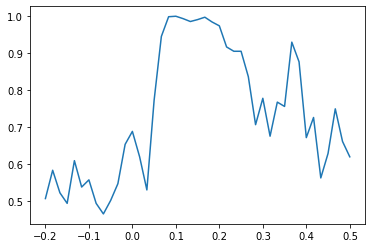

In [18]:
plt.plot(epochs.times, scores.mean(axis=0));

In [20]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression()))


In [21]:
time_decod = SlidingEstimator(clf, scoring='roc_auc')

In [24]:
time_decod.fit(X, y)

<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel', LinearModel(model=LogisticRegression()))]),
         n_jobs=1, scoring='roc_auc', verbose=None, fitted with 43 estimators>

In [25]:
coef = get_coef(time_decod, 'filters_', inverse_transform=True)

In [27]:
coef.shape

(305, 43)

In [28]:
evoked_coef = mne.EvokedArray(coef,
                              epochs.info,
                              tmin=epochs.times[0])

Projections have already been applied. Setting proj attribute to True.


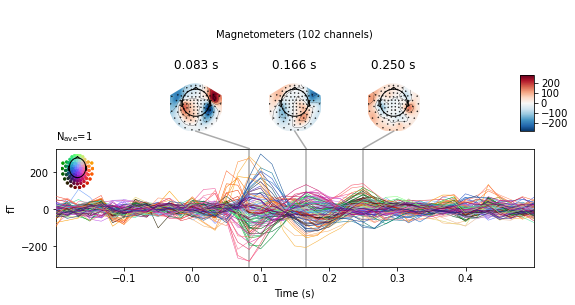

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


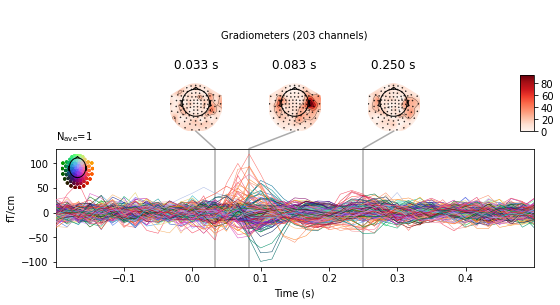

In [30]:
evoked_coef.plot_joint(); 

In [31]:
from sklearn.naive_bayes import GaussianNB

In [32]:
clf_nb = make_pipeline(StandardScaler(), GaussianNB())

In [33]:
time_decod_nb = SlidingEstimator(clf_nb, scoring='roc_auc')

In [34]:
scores_nb = cross_val_multiscore(time_decod_nb, X, y, cv=cv)

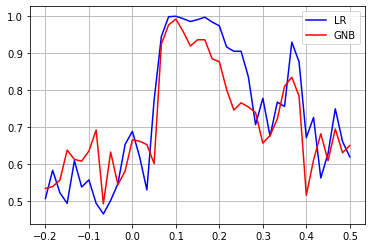

In [44]:
plt.plot(epochs.times, scores.mean(axis=0), 'b', label='LR')
plt.plot(epochs.times, scores_nb.mean(axis=0), 'r', label='GNB');
plt.legend();
plt.grid();

In [37]:
scores.mean()

0.7353669586227725

In [38]:
scores_nb.mean()

0.7148142555119299

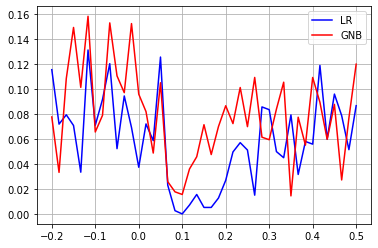

In [45]:
plt.plot(epochs.times ,scores.std(axis=0), 'b', label='LR')
plt.plot(epochs.times ,scores_nb.std(axis=0), 'r', label='GNB')
plt.legend();
plt.grid();